<h3> Necessary imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud,STOPWORDS
import re
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Activation, Embedding, Flatten
from tensorflow.keras.models import Model, Sequential
import random as rn
import pickle

<h3> Fetch data

In [4]:
sentiments_data = pd.read_csv("/content/data.csv")
sentiments_data.head()

,textID,text,sentiment
0,2a0463352b,that`s enough! I`ll do nothing for 2 hours.,neutral
1,f358968122,I have to go clothes shopping tomorrow I hate...,negative
2,449e7733f1,i am bored. :| any idea`s of a nice site?,neutral
3,6099baf6e8,I don`t think will want to come back (guys r...,negative
4,f946da7a04,_thomas if only the drinking game was tonight....,neutral


In [5]:
print("Number of data points in data", sentiments_data.shape)
print('-'*50)
print("The attributes of data :", sentiments_data.columns.values)

Number of data points in data (18899, 3)
--------------------------------------------------
The attributes of data : ['textID' 'text' 'sentiment']


# Exploratory Data Analysis

In [6]:
# Check for null values and drop them
sentiments_data.isnull().sum()
sentiments_data.dropna(inplace=True)
print("Number of data points in data after dropping null values", sentiments_data.shape)

Number of data points in data after dropping null values (18898, 3)


Number of sentiments that are neutral  11117 , ( 58.82633082865911 %)
Number of sentiments that are negative  7781 , ( 41.17366917134088 %)


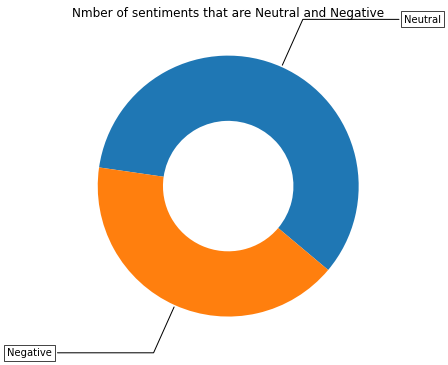

In [ ]:
# class distribution
y_value_counts = sentiments_data['sentiment'].value_counts()
print("Number of sentiments that are neutral ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of sentiments that are negative ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Neutral", "Negative"]

data = [y_value_counts[0], y_value_counts[1]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of sentiments that are Neutral and Negative")

plt.show()

As we can see in above plot, the imbalance in not that much

In [ ]:
sentiments_data.text.values

array(['that`s enough! I`ll do nothing for 2 hours.',
       "I have to go clothes shopping tomorrow  I hate it, but I have a serious 'clothes falling apart' situation here.",
       'i am bored. :| any idea`s of a nice site?', ...,
       'Last night in Australia', 'painting',
       'Is in bed not able to sleep  bloody bipolar!'], dtype=object)

In [ ]:
# statistics for text data length
list_text = [i.split(" ") for i in sentiments_data.text.values]
len_text = [len(text) for text in list_text]
min_len_text = min(len_text)
max_len_text = max(len_text)
mean_len_text = np.mean(len_text)
median_len_text = np.median(len_text)

print ('Minimum length of text data : ', min_len_text)
print ('Maximum length of text data : ', max_len_text)
print ('Mean length of text data : ', mean_len_text)
print ('Median length of text data : ', median_len_text)

Minimum length of text data :  1
Maximum length of text data :  100
Mean length of text data :  13.332416128690866
Median length of text data :  12.0


let's see sentence with maximum length

In [ ]:
for text in list_text:
  if len(text)==100:
    print(text)

['yes', 'indeed', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'here', 'I', 'am', 'again']


Above, we can see that multiple spaces are there in sentences, also I observed multiple dots like ...... are present in data, so we need to get rid of these while preprocessing

In [ ]:
# let's see some small length text and decide if it needs to be removed or not
for i in sentiments_data.text.values:
  if len(i) <6:
    print(i)

mean
Oh no
boo
rain
****
YES!!
Sigh
gmail
Foto!
Hey
aw
Yeah.
Yeah
yeah
why?
bored
I see
rofl
night
Yep.
Why?
Rude.
no
ME
ouch
Also
uh oh
nope
ow
thanx
supp?
Why?
why??
sucks
Thx
Bye.
I did
same
yup
yes
I see
heyy
woOt!
lame
not
Yep!!
awww
with
?
gut
aww
yep
Nope


let's keep the small length text even just one word also, those are making sense

In [7]:
sentiments_data

,textID,text,sentiment
0,2a0463352b,that`s enough! I`ll do nothing for 2 hours.,neutral
1,f358968122,I have to go clothes shopping tomorrow I hate...,negative
2,449e7733f1,i am bored. :| any idea`s of a nice site?,neutral
3,6099baf6e8,I don`t think will want to come back (guys r...,negative
4,f946da7a04,_thomas if only the drinking game was tonight....,neutral
...,...,...,...
18894,4fdc228bbe,"back at school again. almost weekend. oh wait,...",neutral
18895,07726716b7,Bit devastated that I lost my entire documents...,negative
18896,082b93228a,Last night in Australia,neutral
18897,82d99a5bec,painting,neutral


<h1> word frequency visualization for neutral sentiment

In [8]:
neutral_data = sentiments_data[sentiments_data['sentiment']=="neutral"]
negative_data = sentiments_data[sentiments_data['sentiment']=="negative"]

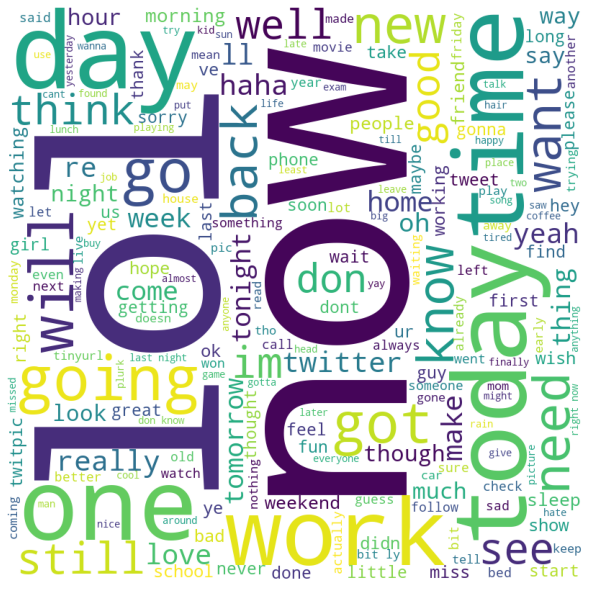

In [10]:
# plot the wordcloud for text data to visualize frequency of words in corpus
#generate word cloud from words in text
stopwords = set(STOPWORDS)
comment_words = ''
 
# iterate through the csv file
for val in neutral_data.text.values:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

As we can see words which occured so many times are now, lol,great,still,day etc

<h1> word frequency visualization for negative sentiment

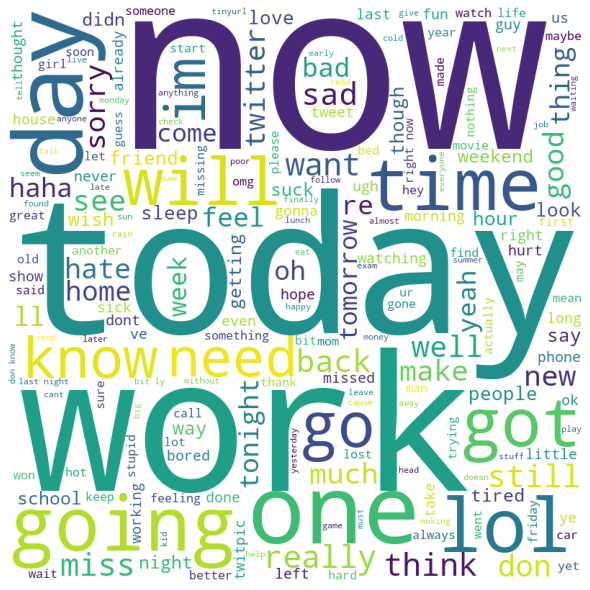

In [11]:
for val in negative_data.text.values:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

We  can see words like today, work, now, time etc. are often present in negative sentiments text

# Preprocessing of text data

We are going to perform these basic steps for preprocessing of text data

Perform de-contraction

Remove multiple spaces and dots 

Remove punctuations

Lowercase the reviews

Remove digits and words containing digits


In [12]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['is', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [14]:
preprocessed_text = []
# tqdm is for printing the status bar
for sentence in tqdm(sentiments_data.text.values):
    sent = decontracted(sentence)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub(' +', ' ', sent) # remove multiple spaces
    sent = re.sub('\.+', ' ', sent) # remove multiple dots
    sent = re.sub('[^A-Za-z]+', ' ', sent) # remove special characters and digits
    sent = sent.lower()
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_text.append(sent.strip())
sentiments_data['preprocessed_text'] = preprocessed_text

100%|██████████| 18898/18898 [00:01<00:00, 16388.86it/s]


In [15]:
# let's check length of text after preprocessing
# statistics for text data length
list_text = [i.split(" ") for i in sentiments_data.preprocessed_text.values]
len_text = [len(text) for text in list_text]
min_len_text = min(len_text)
max_len_text = max(len_text)
mean_len_text = np.mean(len_text)
median_len_text = np.median(len_text)

print ('Minimum length of text data : ', min_len_text)
print ('Maximum length of text data : ', max_len_text)
print ('Mean length of text data : ', mean_len_text)
print ('Median length of text data : ', median_len_text)

Minimum length of text data :  1
Maximum length of text data :  25
Mean length of text data :  7.138056937242037
Median length of text data :  7.0


In [16]:
# saving preprocessed dataframe 
sentiments_data[['textID','sentiment','preprocessed_text']].to_pickle('preprocessed_sentiments_data.pkl')

# Feature Engineering and Modelling

In [17]:
# load preprocessed data
sentiments_data = pd.read_pickle('preprocessed_sentiments_data.pkl')

In [18]:
# convert labels to numerical format
le=LabelEncoder()
sentiments_data['label'] = le.fit_transform(sentiments_data.sentiment.values)
# neutral is mapped to 1 and negative is mapped to 0

In [19]:
# train - test split
X = sentiments_data.preprocessed_text.values
y = sentiments_data.label.values
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size = 0.2, random_state = 0)
print("Train data shape input and output" , X_train.shape,y_train.shape)
print("Test data shape input and output" , X_test.shape,y_test.shape)

Train data shape input and output (15118,) (15118,)
Test data shape input and output (3780,) (3780,)


To create features from text data we are going to try two methods

1. TF-IDF

2. Embedding based

## TF-IDF based featurization

In [21]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df=10,max_features=2000)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [22]:
# Going to use Decision Tree model, before that we need to find best hyperpaameters
depth =[1, 5, 10, 50, 100, 500, 100]
min_samples_split=[5, 10, 100, 500]
grid_params={'max_depth':depth,'min_samples_split':min_samples_split}
#grid_search=GridSearchCV(estimator=classifier,param_grid=parameters,scoring='AUC',cv=10,n_jobs=-1)
clf =DecisionTreeClassifier()
randomized_search=RandomizedSearchCV(clf,grid_params,cv=3,scoring='roc_auc')
randomized_search.fit(tfidf_train,y_train)
print(randomized_search.best_score_)
print(randomized_search.best_params_)

0.7369229712212192
{'min_samples_split': 500, 'max_depth': 100}


In [23]:
# Now train the model with above hyperparameters and performing calibration on top
dt_clf=DecisionTreeClassifier(max_depth=100, min_samples_split= 500,class_weight='balanced')
dt_clf.fit(tfidf_train,y_train)
sig_clf=CalibratedClassifierCV(dt_clf,method='sigmoid')
sig_clf.fit(tfidf_train,y_train)
y_pred_matrix=sig_clf.predict_proba(tfidf_test)
y_pred_tr_matrix=sig_clf.predict_proba(tfidf_train)
y_pred=np.zeros((len(y_test),1))
y_pred_tr=np.zeros((len(y_train),1))
for i in range(y_pred_tr_matrix.shape[0]):
   y_pred_tr[i,0]=np.amax(y_pred_tr_matrix[i,:])
print(y_pred_tr.shape)
for i in range(y_pred_matrix.shape[0]):
   y_pred[i,0]=np.amax(y_pred_matrix[i,:])
print(y_pred.shape)

(15118, 1)
(3780, 1)


train AUC 0.6316557020725924
test AUC 0.6039299304914791


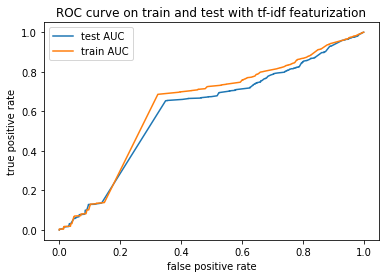

In [24]:
# plot roc_auc curve for tf-idf 
from sklearn.metrics import roc_curve,roc_auc_score
fpr,tpr,threshold=roc_curve(y_test,y_pred)
plt.plot(fpr,tpr,label='test AUC')
fpr_tr,tpr_tr,threshold_tr=roc_curve(y_train,y_pred_tr)
plt.plot(fpr_tr,tpr_tr,label='train AUC')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
#print roc_auc score #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
auc1=roc_auc_score(y_test,y_pred, average='macro', sample_weight=None)
auc1_tr=roc_auc_score(y_train,y_pred_tr, average='macro', sample_weight=None)
print("train AUC", auc1_tr)
print("test AUC", auc1)
plt.legend()
plt.title('ROC curve on train and test with tf-idf featurization')
plt.show()

From above plot, we can say that model is having okay performance but not too good, so we are going to try deep learning techniques to improve performance

## Deep Learning Methods

In [25]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(X_train)
vector_train = tokenizer.texts_to_sequences(X_train)
vector_test = tokenizer.texts_to_sequences(X_test)

In [26]:
#extracting embedding for each word
import numpy as np
embeddings_index = dict()
f = open('/content/drive/MyDrive/glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()

In [28]:
vocab_size = len(tokenizer.word_index) + 1

In [32]:
#creating an embedding matrix 
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector
max_len = 25

In [33]:
padded_vectors_train = np.array( tf.keras.preprocessing.sequence.pad_sequences(vector_train, maxlen=max_len, padding='post'))
padded_vectors_test = np.array( tf.keras.preprocessing.sequence.pad_sequences(vector_test, maxlen=max_len, padding='post'))

<h3> Let's begin creation of model

In [34]:
tf.keras.backend.clear_session()

Input_layer = Input(shape = (max_len))
Embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_len,trainable=False)(Input_layer)

conv_layer1 = tf.keras.layers.Conv1D(8, 10, strides=1, padding='valid',kernel_regularizer=tf.keras.regularizers.l2(0.001))(Embedding_layer)
conv_layer2 = tf.keras.layers.Conv1D(8,15,strides=1, padding='valid',kernel_regularizer=tf.keras.regularizers.l2(0.01))(Embedding_layer)
conv_layer3 =tf.keras.layers.Conv1D(8,5,strides=1, padding='valid',kernel_regularizer=tf.keras.regularizers.l2(0.001))(Embedding_layer)

concatenate_layer = tf.keras.layers.Concatenate(axis=1)(inputs = [conv_layer1, conv_layer2,conv_layer3])

max_pool_layer1=tf.keras.layers.MaxPool1D(pool_size=3, strides=None, padding='valid', data_format='channels_last')(concatenate_layer)

conv_layer4 = tf.keras.layers.Conv1D(8, 6, strides=1, padding='valid',kernel_regularizer=tf.keras.regularizers.l2(0.001))(max_pool_layer1)
conv_layer5 = tf.keras.layers.Conv1D(8,4,strides=1, padding='valid',kernel_regularizer=tf.keras.regularizers.l2(0.01))(max_pool_layer1)
conv_layer6 =tf.keras.layers.Conv1D(8,8,strides=1, padding='valid',kernel_regularizer=tf.keras.regularizers.l2(0.1))(max_pool_layer1)


concatenate_layer2 = tf.keras.layers.Concatenate(axis=1)(inputs = [conv_layer4, conv_layer5,conv_layer6])

max_pool_layer2=tf.keras.layers.MaxPool1D(pool_size=3, strides=None, padding='valid', data_format='channels_last')(concatenate_layer2)

conv_layer7 =tf.keras.layers.Conv1D(12,8,strides=1, padding='valid',kernel_regularizer=tf.keras.regularizers.l2(0.01))(max_pool_layer2)
flatten_layer2 = Flatten()(conv_layer7)
dropout_layer = tf.keras.layers.Dropout(0.2)(flatten_layer2)
dense_layer = (Dense(64, activation='relu'))(dropout_layer)

output_layer = (Dense(1, activation='sigmoid'))(dense_layer)

model = tf.keras.Model(inputs=[Input_layer],outputs=output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 25, 100)      1721500     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 16, 8)        8008        ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 11, 8)        12008       ['embedding[0][0]']              
                                                                                              

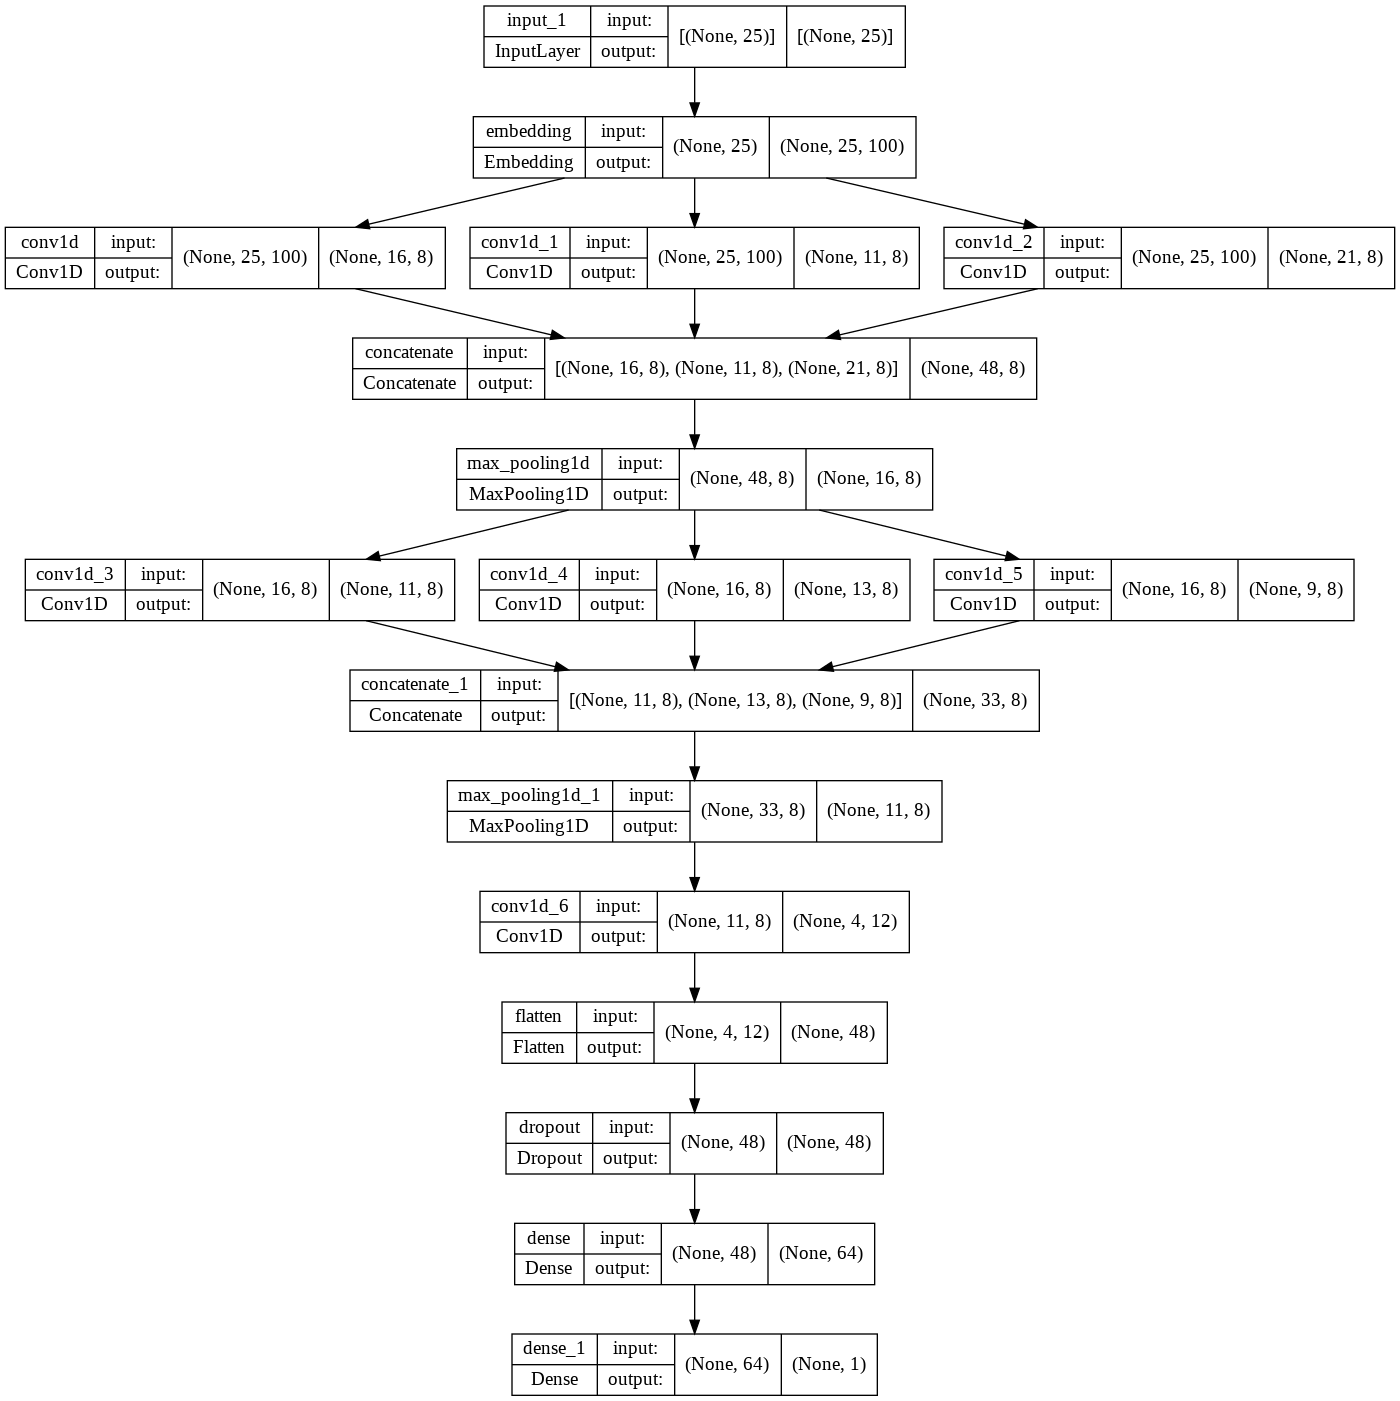

In [35]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [36]:
#check points callback
from tensorflow.keras.callbacks import ModelCheckpoint

filepath="weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='max')

# Early stopping callback
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.35, patience=3, verbose=1)

# Tensorboard for visualization
%load_ext tensorboard
import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True,write_grads=True)

In [37]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.AUC(name = 'auc')])

In [38]:
model.fit(padded_vectors_train,y_train,batch_size=256,epochs =8,validation_data=(padded_vectors_test,y_test),callbacks=[earlystop,checkpoint,tensorboard_callback])

Epoch 1/8
59/60 [============================>.] - ETA: 0s - loss: 0.7919 - accuracy: 0.6756 - auc: 0.7249
Epoch 1: val_accuracy improved from -inf to 0.73148, saving model to weights-01-0.7315.hdf5
60/60 [==============================] - 10s 98ms/step - loss: 0.7918 - accuracy: 0.6756 - auc: 0.7249 - val_loss: 0.6038 - val_accuracy: 0.7315 - val_auc: 0.7947
Epoch 2/8
59/60 [============================>.] - ETA: 0s - loss: 0.5834 - accuracy: 0.7391 - auc: 0.8020
Epoch 2: val_accuracy did not improve from 0.73148
60/60 [==============================] - 6s 101ms/step - loss: 0.5836 - accuracy: 0.7390 - auc: 0.8018 - val_loss: 0.6077 - val_accuracy: 0.6997 - val_auc: 0.8017
Epoch 3/8
59/60 [============================>.] - ETA: 0s - loss: 0.5683 - accuracy: 0.7468 - auc: 0.8128
Epoch 3: val_accuracy improved from 0.73148 to 0.74021, saving model to weights-03-0.7402.hdf5
60/60 [==============================] - 7s 120ms/step - loss: 0.5684 - accuracy: 0.7466 - auc: 0.8127 - val_loss: 

The model performs well, that shows us how convolution works even for text classification. The auc scores are pretty good. By taking more number of filters we can improve

prediction on 10 sample test inputs

In [47]:
predicted_labels = []
predictions = model.predict(padded_vectors_test)
for i in predictions:
  if i > 0.5:
    predicted_labels.append("neutral")
  else:
    predicted_labels.append("negative")
# ground truth map to original labels instead of 1 and 0
ground_truth = []
for i in y_test:
  if i == 1:
    ground_truth.append("neutral")
  elif i == 0 :
    ground_truth.append("negative")

<h2> Actual VS Predicted Comparison on first 10 test data points to observe model performance

In [59]:
comparison_df=pd.DataFrame()
comparison_df['input'] = X_test[:10]
comparison_df['Actual'] = ground_truth[:10]
comparison_df['predicted'] = predicted_labels[:10]
print(comparison_df)

                                                                                              input  \
0  saying http bctiny com po                                                                          
1  kind figured probably unable reason lot things manga happen way happen                             
2  sad best friend selfish heartless exclude life completely sad                                      
3  yeah dude would ask already know                                                                   
4  lol half already bulky desktop geared super slim light ssd performance unreal                      
5  transcribing tenth last report night                                                               
6  get bitten rabies infested person last night yay gonna scare rachel quarantine tonight shall fun   
7  ah misunderstood message really dislike f word url good luck march                                 
8  hungry sub                                                            

We can see out of these 10 test inputs, 8 predictions are absolutely correct, we can say model is performing well we can do post training analysis further to improve for edge cases.